In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from linalg import *

In [4]:
sndata = pd.read_csv('lcparam_full_long.txt', sep=' ', skiprows=0)
z = sndata['zcmb'].to_numpy()
mb = sndata['mb'].to_numpy()
dmb = sndata['dmb'].to_numpy()

In [5]:
dmb_matrix = np.diag(dmb**2)  # Covariance matrix assuming uncorrelated errors

In [6]:
cov_flatten = np.loadtxt('sys_full_long.txt', delimiter=' ')
cov_T = []
for i in range(1048):
    cov_row = cov_flatten[i*1048:(i+1)*1048]
    cov_T.append(cov_row)
cov = np.array(cov_T) + dmb_matrix

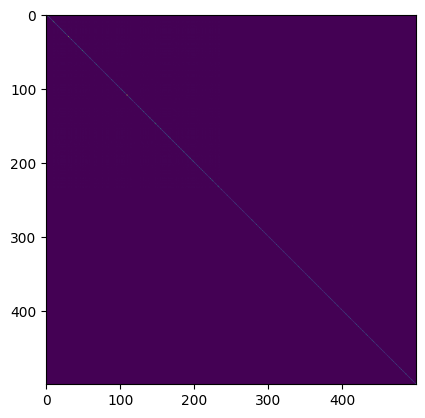

In [33]:
plt.imshow(cov[:500,:500], cmap='viridis')

In [7]:
from scipy.integrate import quad
from scipy.interpolate import interp1d


#inv_cov = inv_matrix(cov)
class Regression:
    def __init__(self):
        pass
    def read_data(self, **kwargs):
        data = kwargs['data'] if 'data' in kwargs else None
        cov = kwargs['cov'] if 'cov' in kwargs else None
        if data is None or cov is None:
            raise ValueError("Data must be provided for regression.")
        self.z = data['zcmb'].to_numpy()
        self.mb = data['mb'].to_numpy()
        self.dmb = data['dmb'].to_numpy()
        self.inv_cov = inv_matrix(cov)
        self.zinterp = np.linspace(min(self.z), max(self.z), 100)
        print("Data and covariance matrix successfully read.")
        print(f"Number of data points: {len(self.z)}")
        print(f"Covariance matrix shape: {cov.shape}")
    def inverse_h_th(self, redshift, Om0): # c/h(z), hz = sqrt(Om0*(1+z)^3 + (1-Om0))
        speed_of_light = 299792.458  # in km/s
        return speed_of_light/np.sqrt(1-Om0 + Om0*(1+redshift)**3)
    def mb_th(self, Om0):
        zinterp = self.zinterp
        int_arr = np.array([quad(self.inverse_h_th, 0, zi, args=(Om0,))[0] for zi in zinterp])
        interp = interp1d(zinterp, int_arr) # D_L (in Mpc) / (c/H0)
        mb = 5*np.log10(1+self.z) + 5*np.log10(interp(self.z))
        return mb

    def residual_plus_alpha(self,Om0,alpha): # alpha = -5logH0 + M
        return self.mb - self.mb_th(Om0) + alpha
    def predict_alpha(self, Om0, vec_func): # analytical marginalization over alpha
        one_vec = np.ones(len(self.z))
        def derivative_chisq(Om0, a):
            return one_vec @ self.inv_cov @ vec_func(Om0, a).T + vec_func(Om0, a) @ self.inv_cov @ one_vec.T
        a_range = np.linspace(-100,100,21) # increment of 10
        i=0
        for i in range(4 + 2): # precision of 1e-4
            derivatives = np.array([derivative_chisq(Om0, a_s) for a_s in a_range])
            zero_crossings = np.where(np.diff(np.sign(derivatives)))[0]
            if len(zero_crossings) == 0:
                raise ValueError("No zero crossings found, increase range.")
            a_range = np.linspace(a_range[zero_crossings[0]], a_range[zero_crossings[0]+1], 21)
            i += 1
        derivatives = np.array([derivative_chisq(Om0, a_s) for a_s in a_range])
        zero_crossings = np.where(np.diff(np.sign(derivatives)))[0] # final precision of 1e-5
        marg_a_val = (a_range[zero_crossings[0]] + a_range[zero_crossings[0]+1]) / 2
        return marg_a_val # this alpha minimizes chi-square for given Om0

    def chisq(self, Om0):
        alpha = self.predict_alpha(Om0, self.residual_plus_alpha)
        chisq_val = self.residual_plus_alpha(Om0, alpha) @ self.inv_cov @ self.residual_plus_alpha(Om0, alpha).T
        return chisq_val
    def find_min_chisq(self):
        Om0_arr = np.linspace(0., 1.0, 11)
        for i in range(2): # precision of 1e-3
        
            chisq_arr = np.array([self.chisq(Om0) for Om0 in Om0_arr])
            print(chisq_arr)
            min_chisq_om0 = Om0_arr[np.argmin(chisq_arr)]
            Om0_arr = np.linspace(min_chisq_om0 - 0.1**(i+1), min_chisq_om0 + 0.1**(i+1), 21)
            print('Om0_arr:', Om0_arr)
        chisq_arr = np.array([self.chisq(Om0) for Om0 in Om0_arr])
        self.bfOm0 = Om0_arr[np.argmin(chisq_arr)]
        self.bfChisq = np.min(chisq_arr)
        return self.bfOm0, self.bfChisq
    
    def delta_chisq(self, Om0_arr):
        delta_chisq_arr = np.array([self.chisq(Om0) - self.bfChisq for Om0 in Om0_arr])
        return delta_chisq_arr

            
            
    

In [8]:
Reg = Regression()
Reg.read_data(data = sndata, cov=cov)

Data and covariance matrix successfully read.
Number of data points: 1048
Covariance matrix shape: (1048, 1048)


In [9]:
Reg.find_min_chisq()

[1393.16848728 1146.52223897 1050.81229296 1026.70306198 1044.80682668
 1090.08847221 1153.73679408 1230.15606473 1315.59585321 1407.44329078
 1503.82443858]
Om0_arr: [0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33
 0.34 0.35 0.36 0.37 0.38 0.39 0.4 ]
[1050.81229296 1045.84666428 1041.53064133 1037.82946099 1034.71096318
 1032.1453252  1030.10483081 1028.56366863 1027.49775515 1026.88457879
 1026.70306198 1026.9334386  1027.55714479 1028.55672137 1029.91572624
 1031.6186557  1033.65087343 1035.99854627 1038.64858608 1041.58859686
 1044.80682668]
Om0_arr: [0.29  0.291 0.292 0.293 0.294 0.295 0.296 0.297 0.298 0.299 0.3   0.301
 0.302 0.303 0.304 0.305 0.306 0.307 0.308 0.309 0.31 ]


(np.float64(0.29900000000000004), np.float64(1026.702362079202))

In [10]:
from scipy.stats import norm, chi2

conf_interv = []
for i in range(3):
    conf_interv.append(norm.cdf(i+1) - norm.cdf(-i-1))
chi2_vals = []
for j in range(len(conf_interv)):
    chi2_vals.append(chi2.ppf(conf_interv[j], df=1))

In [11]:
Om0_arr = np.linspace(0.3-0.1, 0.3+0.1, 50)
delta_chisq = Reg.delta_chisq(Om0_arr)

In [12]:
conf_sig1 = [np.min(Om0_arr[np.argwhere(delta_chisq < chi2_vals[0])]), np.max(Om0_arr[np.argwhere(delta_chisq < chi2_vals[0])])]
conf_sig2 = [np.min(Om0_arr[np.argwhere(delta_chisq < chi2_vals[1])]), np.max(Om0_arr[np.argwhere(delta_chisq < chi2_vals[1])])]
conf_sig3 = [np.min(Om0_arr[np.argwhere(delta_chisq < chi2_vals[2])]), np.max(Om0_arr[np.argwhere(delta_chisq < chi2_vals[2])])]

In [13]:
conf_sig3

[np.float64(0.236734693877551), np.float64(0.36734693877551017)]

In [17]:
print(f"1 - sigma confidence interval : + {(conf_sig1[1] - Reg.bfOm0):.4f} - {Reg.bfOm0 - conf_sig1[0]:.4f}")
print(f"2 - sigma confidence interval : + {(conf_sig2[1] - Reg.bfOm0):.4f} - {Reg.bfOm0 - conf_sig2[0]:.4f}")
print(f"3 - sigma confidence interval : + {(conf_sig3[1] - Reg.bfOm0):.4f} - {Reg.bfOm0 - conf_sig3[0]:.4f}")

1 - sigma confidence interval : + 0.0194 - 0.0174
2 - sigma confidence interval : + 0.0439 - 0.0419
3 - sigma confidence interval : + 0.0683 - 0.0623


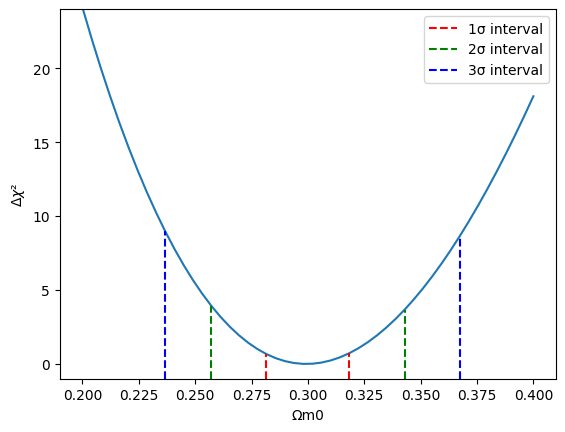

In [ ]:

plt.plot(Om0_arr, delta_chisq)
plt.ylim([-1,24])
plt.vlines(conf_sig1[0],-1, delta_chisq[np.where(Om0_arr == conf_sig1[0])][0], color='r', linestyle='--', label=f'1σ interval = ')
plt.vlines(conf_sig1[1],-1, delta_chisq[np.where(Om0_arr == conf_sig1[1])][0], color='r', linestyle='--')
plt.vlines(conf_sig2[0],-1, delta_chisq[np.where(Om0_arr == conf_sig2[0])][0], color='g', linestyle='--', label='2σ interval')
plt.vlines(conf_sig2[1],-1, delta_chisq[np.where(Om0_arr == conf_sig2[1])][0], color='g', linestyle='--')
plt.vlines(conf_sig3[0],-1, delta_chisq[np.where(Om0_arr == conf_sig3[0])][0], color='b', linestyle='--', label='3σ interval')
plt.vlines(conf_sig3[1],-1, delta_chisq[np.where(Om0_arr == conf_sig3[1])][0], color='b', linestyle='--')
plt.xlabel('Ωm0')
plt.ylabel(r'$\Delta χ²$')
plt.legend()